# Intro to neural net training with autograd

In this notebook, we'll practice

* using the **autograd** Python package to compute gradients
* using gradient descent to train a basic linear regression (a NN with 0 hidden layers)
* using gradient descent to train a basic neural network for regression (NN with 1+ hidden layers)


### Requirements:

Standard `comp135_env`, PLUS the `autograd` package: https://github.com/HIPS/autograd

To install autograd, first activate your `comp135_env`, and then do:
```
pip install autograd
```

### Outline

* Part 1: Autograd for scalar input -> scalar output functions
* Part 2: Autograd for vector input -> scalar output functions
* Part 3: Using autograd inside a simple gradient descent procedure
* Part 4: Using autograd to solve linear regression

In [1]:
import pickle
import copy
import time

In [2]:
## Import plotting tools

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
## Import numpy
import numpy as np
import pandas as pd

In [4]:
## Import autograd
import autograd.numpy as ag_np
import autograd

# PART 1: Using autograd's 'grad' function on univariate functions

Suppose we have a mathematical function of interest $f(x)$. For now, we'll work with functions that have a scalar input and scalar output. 

Then we can of course ask: what is the derivative (aka *gradient*) of this function:

$$
g(x) \triangleq \frac{\partial}{\partial x} f(x)
$$

Instead of computing this gradient by hand via calculus/algebra, we can use autograd to do it for us.

First, we need to implement the math function $f(x)$ as a **Python function** `f`.


The Python function `f` needs to satisfy the following requirements:
* INPUT 'x': scalar float
* OUTPUT 'f(x)': scalar float
* All internal operations are composed of calls to functions from `ag_np`, the `autograd` version of numpy

**Important:**
* You might be used to importing numpy as `import numpy as np`, and then using this shorthand for `np.cos(0.0)` or `np.square(5.0)` etc.
* For autograd to work, you need to instead use **autograd's** provided numpy wrapper interface: `from autograd.numpy as ag_np`
* The `ag_np` module has the same API as `numpy`, so you can call `ag_np.cos(0.0)`, `ag_np.square(5.0)`, etc.

Now, if `f` meeds the above requirements, we can create a Python function `g` to compute derivatives of $f(x)$ by calling `autograd.grad`:

```
g = autograd.grad(f)
```

The symbol `g` is now a **Python function** that takes the same input as `f`, but produces the derivative at a given input.



In [5]:
def f(x):
    return ag_np.square(x)

g = autograd.grad(f)

In [6]:
f(4.0)

16.0

In [7]:
# 'g' is just a function. You can call it as usual, by providing a possible scalar float input

g(0.0)

0.0

In [8]:
[g(-1.0), g(1.0)]

[-2.0, 2.0]

### Plot to demonstrate the gradient function  side-by-side with original function

Text(0.5, 1.0, 'gradient of f(x)')

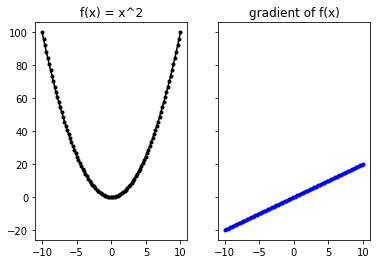

In [9]:
x_grid_G = np.linspace(-10, 10, 100)

fig_h, subplot_grid = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, squeeze=False)
subplot_grid[0,0].plot(x_grid_G, [f(x_g) for x_g in x_grid_G], 'k.-')
subplot_grid[0,0].set_title('f(x) = x^2')

subplot_grid[0,1].plot(x_grid_G, [g(x_g) for x_g in x_grid_G], 'b.-')
subplot_grid[0,1].set_title('gradient of f(x)')


## Exercise 1a:

Consider the decaying periodic function below. Can you compute its derivative using autograd and plot the result?

$$
f(x) = e^{-x/10} * cos(x)
$$

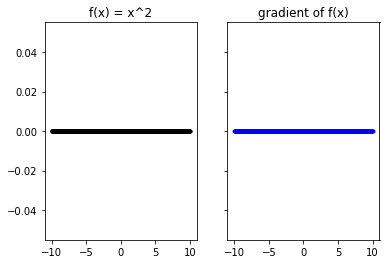

In [10]:
def f(x):
    return 0.0 # TODO compute the function above, using 'ag_np'
    
g = f # TODO define g as gradient of f, using autograd's `grad` 

# TODO plot the result
x_grid_G = np.linspace(-10, 10, 500)
fig_h, subplot_grid = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, squeeze=False)
subplot_grid[0,0].plot(x_grid_G, [f(x_g) for x_g in x_grid_G], 'k.-');
subplot_grid[0,0].set_title('f(x) = x^2');

subplot_grid[0,1].plot(x_grid_G, [g(x_g) for x_g in x_grid_G], 'b.-');
subplot_grid[0,1].set_title('gradient of f(x)');

# PART 2: Using autograd's 'grad' function on functions with multivariate input


Now, imagine the input $x$ could be a vector of size D. 

Our mathematical function $f(x)$ will map each input vector to a scalar.

We want the gradient function

\begin{align}
g(x) &\triangleq \nabla_x f(x)
\\
&= [
    \frac{\partial}{\partial x_1} f(x)
    \quad \frac{\partial}{\partial x_2} f(x)
    \quad \ldots \quad \frac{\partial}{\partial x_D} f(x)  ]
\end{align}

Instead of computing this gradient by hand via calculus/algebra, we can use autograd to do it for us.

First, we implement math function $f(x)$ as a **Python function** `f`.

The Python function `f` needs to satisfy the following requirements:
* INPUT 'x': numpy array of float
* OUTPUT 'f(x)': scalar float
* All internal operations are composed of calls to functions from `ag_np`, the `autograd` version of numpy


In [11]:
def f(x_D):
    return ag_np.sum(ag_np.square(x_D))

g = autograd.grad(f)

In [12]:
x_D = np.zeros(4)
print(x_D)
print(f(x_D))
print(g(x_D))

[0. 0. 0. 0.]
0.0
[0. 0. 0. 0.]


In [13]:
x_D = np.asarray([1., 2., 3., 4.])
print(x_D)
print(f(x_D))
print(g(x_D))

[1. 2. 3. 4.]
30.0
[2. 4. 6. 8.]


# Part 3: Using autograd gradients within gradient descent to solve multivariate optimization problems 

### Helper function: basic gradient descent

Here's a very simple function that will perform many gradient descent steps to optimize a given function.


In [14]:
def run_many_iters_of_gradient_descent(f, g, init_x_D=None, n_iters=100, step_size=0.001):

    # Copy the initial parameter vector
    x_D = copy.deepcopy(init_x_D)

    # Create data structs to track the per-iteration history of different quantities
    history = dict(
        iter=[],
        f=[],
        x_D=[],
        g_D=[])

    for iter_id in range(n_iters):
        if iter_id > 0:
            x_D = x_D - step_size * g(x_D)

        history['iter'].append(iter_id)
        history['f'].append(f(x_D))
        history['x_D'].append(x_D)
        history['g_D'].append(g(x_D))
    return x_D, history

### Worked Example 3a: Minimize f(x) = sum(square(x))

It's easy to figure out that the vector with smallest L2 norm (smallest sum of squares) is the all-zero vector.

Here's a quick example of showing that using gradient functions provided by autograd can help us solve the optimization problem:

$$
\min_x  \sum_{d=1}^D x_d^2
$$

In [15]:
def f(x_D):
    return ag_np.sum(ag_np.square(x_D))

g = autograd.grad(f)

# Initialize at x_D = [-3, 4, -5, 6]
init_x_D = np.asarray([-3.0, 4.0, -5.0, 6.0])

In [16]:
opt_x_D, history = run_many_iters_of_gradient_descent(f, g, init_x_D, n_iters=1000, step_size=0.01)

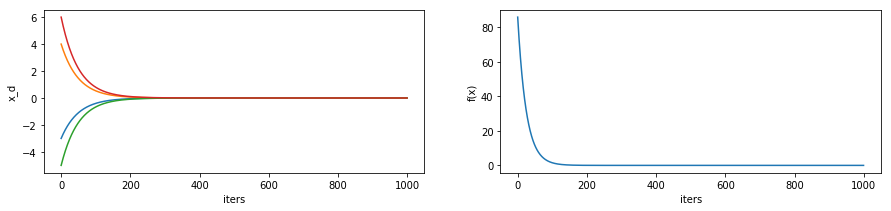

In [17]:
# Make plots of how x parameter values evolve over iterations, and function values evolve over iterations
# Expected result: f goes to zero. all x values goto zero.

fig_h, subplot_grid = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=False, figsize=(15,3), squeeze=False)
subplot_grid[0,0].plot(history['iter'], history['x_D'])
subplot_grid[0,0].set_xlabel('iters')
subplot_grid[0,0].set_ylabel('x_d')

subplot_grid[0,1].plot(history['iter'], history['f'])
subplot_grid[0,1].set_xlabel('iters')
subplot_grid[0,1].set_ylabel('f(x)');

### Try it Example 3b: Minimize the 'trid' function

Given a 2-dimensional vector $x = [x_1, x_2]$, the trid function is:

$$
f(x) = (x_1-1)^2 + (x_2-1)^2 - x_1 x_2
$$

Background and Picture: <https://www.sfu.ca/~ssurjano/trid.html>

Can you use autograd + gradient descent to find the optimal value $x^*$ that minimizes $f(x)$?

You can initialize your gradient descent at [+1.0, -1.0]

In [18]:
def f(x_D):
    return 0.0 # TODO

g = f # TODO

In [19]:
# TODO call run_many_iters_of_gradient_descent() with appropriate args

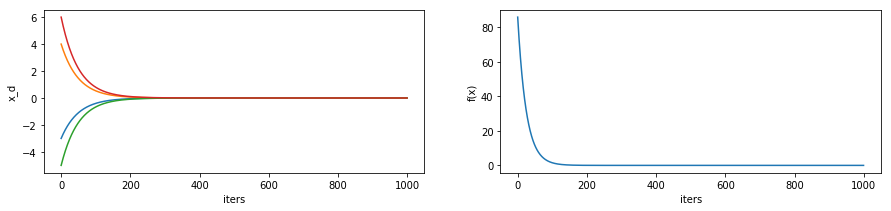

In [20]:
# TRID example
# Make plots of how x parameter values evolve over iterations, and function values evolve over iterations
# Expected result: ????

fig_h, subplot_grid = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=False, figsize=(15,3), squeeze=False)
subplot_grid[0,0].plot(history['iter'], history['x_D'])
subplot_grid[0,0].set_xlabel('iters')
subplot_grid[0,0].set_ylabel('x_d')

subplot_grid[0,1].plot(history['iter'], history['f'])
subplot_grid[0,1].set_xlabel('iters')
subplot_grid[0,1].set_ylabel('f(x)');

# Part 4: Solving linear regression with gradient descent + autograd

We observe $N$ examples $(x_i, y_i)$ consisting of D-dimensional 'input' vectors $x_i$ and scalar outputs $y_i$.

Consider the multivariate linear regression model:

\begin{align}
y_i &\sim \mathcal{N}(w^T x_i, \sigma^2), \forall i \in 1, 2, \ldots N
\end{align}
where we assume $\sigma = 0.1$.

One way to train weights would be to just compute the maximum likelihood solution:

\begin{align}
\min_w  - \log p(y | w, x)
\end{align}


## Toy Data for linear regression task

We'll generate data that comes from an idealized linear regression model.

Each example has D=2 dimensions for x.

The first dimension is weighted by +4.2.
The second dimension is weighted by -4.2


In [21]:
N = 100
D = 2
sigma = 0.1

true_w_D = np.asarray([4.2, -4.2])
true_bias = 0.1

train_prng = np.random.RandomState(0)
x_ND = train_prng.uniform(low=-5, high=5, size=(N,D))
y_N = np.dot(x_ND, true_w_D) + true_bias + sigma * train_prng.randn(N)

## Toy Data Visualization: Pairplots for all possible (x_d, y) combinations

You can clearly see the slopes of the lines:
* x1 vs y plot: slope is around +4
* x2 vs y plot: slope is around -4

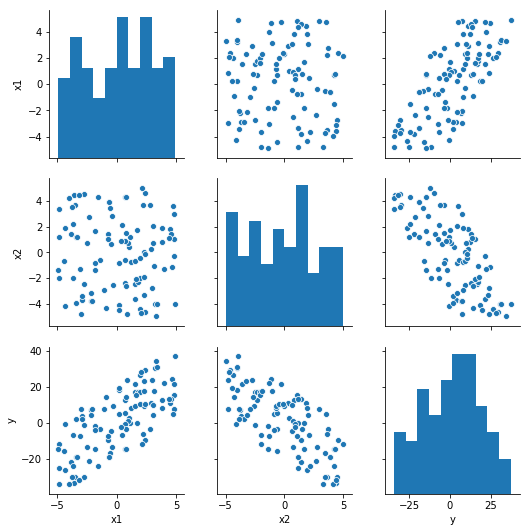

In [22]:
sns.pairplot(
    data=pd.DataFrame(np.hstack([x_ND, y_N[:,np.newaxis]]), columns=['x1', 'x2', 'y']));

In [23]:
# Define the optimization problem as an AUTOGRAD-able function wrt the weights w_D
def calc_neg_likelihood_linreg(w_D):
    return 0.5 / ag_np.square(sigma) * ag_np.sum(ag_np.square(ag_np.dot(x_ND, w_D) - y_N))

In [24]:
## Test the function at an easy initial point
init_w_D = np.zeros(2)
calc_neg_likelihood_linreg(init_w_D)

1521585.0576643152

In [25]:
## Test the gradient at that easy point 
calc_grad_wrt_w = autograd.grad(calc_neg_likelihood_linreg)
calc_grad_wrt_w(init_w_D)

array([-357441.84423006,  367223.20042115])

In [26]:
# Because the gradient's magnitude is very large, use very small step size
opt_w_D, history = run_many_iters_of_gradient_descent(
    calc_neg_likelihood_linreg, autograd.grad(calc_neg_likelihood_linreg), init_w_D,
    n_iters=300, step_size=0.000001,
    )

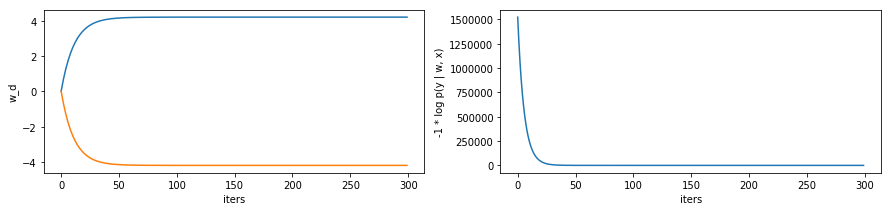

In [27]:
# LinReg worked example
# Make plots of how w_D parameter values evolve over iterations, and function values evolve over iterations
# Expected result: x

fig_h, subplot_grid = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=False, figsize=(15,3), squeeze=False)
subplot_grid[0,0].plot(history['iter'], history['x_D'])
subplot_grid[0,0].set_xlabel('iters')
subplot_grid[0,0].set_ylabel('w_d')

subplot_grid[0,1].plot(history['iter'], history['f'])
subplot_grid[0,1].set_xlabel('iters')
subplot_grid[0,1].set_ylabel('-1 * log p(y | w, x)');

## Try it Example 4b: Solve the linear regression problem using a weights-and-bias representation

The above example only uses weights on the dimensions of $x_i$, and thus can only learn linear models that pass through the origin.

Can you instead optimize a model that includes a **bias** term $b>0$?

\begin{align}
y_i &\sim \mathcal{N}(w^T x_i + b, \sigma^2), \forall i \in 1, 2, \ldots N
\end{align}
where we assume $\sigma = 0.1$.

One non-Bayesian way to train weights would be to just compute the maximum likelihood solution:

\begin{align}
\min_{w,b}  - \log p(y | w, b, x)
\end{align}


An easy way to do this is to imagine that each observation vector $x_i$ is expanded into a $\tilde{x}_i$ that contains a column of all ones.  Then, we can write the corresponding expanded weights as $\tilde{w} = [w_1 w_2 b]$.


\begin{align}
\min_{\tilde{w}}  - \log p(y | \tilde{w},\tilde{x})
\end{align}


In [28]:
# Now, each expanded xtilde vector has size E = D+1 = 3

xtilde_NE = np.hstack([x_ND, np.ones((N,1))])

In [29]:
# TODO: Define f to minimize that takes a COMBINED weights-and-bias vector wtilde_E of size E=3

In [30]:
# TODO: Compute gradient of f

In [31]:
# TODO run gradient descent and plot the results

# Part 5 setup: Autograd for functions of data structures of arrays

#### Useful Fact: autograd can take derivatives with respect to DATA STRUCTURES of parameters

This can help us when it is natural to define models in terms of several parts (e.g. NN layers).

We don't need to turn our many model parameters into one giant weights-and-biases vector. We can express our thoughts more naturally.

### Demo 1: gradient of a LIST of parameters

In [32]:
def f(w_list_of_arr):
    return ag_np.sum(ag_np.square(w_list_of_arr[0])) + ag_np.sum(ag_np.square(w_list_of_arr[1]))

g = autograd.grad(f)

In [33]:
w_list_of_arr = [np.zeros(3), np.arange(5, dtype=np.float64)]

print("Type of the gradient is: ")
print(type(g(w_list_of_arr)))

print("Result of the gradient is: ")
g(w_list_of_arr)

Type of the gradient is: 
<class 'list'>
Result of the gradient is: 


[array([0., 0., 0.]), array([0., 2., 4., 6., 8.])]

### Demo 2: gradient of DICT of parameters


In [34]:
def f(dict_of_arr):
    return ag_np.sum(ag_np.square(dict_of_arr['weights'])) + ag_np.sum(ag_np.square(dict_of_arr['bias']))
g = autograd.grad(f)

In [35]:
dict_of_arr = dict(weights=np.arange(5, dtype=np.float64), bias=4.2)

print("Type of the gradient is: ")
print(type(g(dict_of_arr)))

print("Result of the gradient is: ")
g(dict_of_arr)

Type of the gradient is: 
<class 'dict'>
Result of the gradient is: 


{'weights': array([0., 2., 4., 6., 8.]), 'bias': array(8.4)}

# Part 5: Neural Networks and Autograd

### Let's use a convenient data structure for NN model parameters

Use a list of dicts of arrays.

Each entry in the list is a dict that represents the parameters of one "layer".

Each layer-specific dict has two named attributes: a vector of weights 'w' and a vector of biases 'b'

#### Here's a function to create NN params as a 'list-of-dicts' that match a provided set of dimensions

In [36]:
def make_nn_params_as_list_of_dicts(
        n_hiddens_per_layer_list=[5],
        n_dims_input=1,
        n_dims_output=1,
        weight_fill_func=np.zeros,
        bias_fill_func=np.zeros):
    nn_param_list = []
    n_hiddens_per_layer_list = [n_dims_input] + n_hiddens_per_layer_list + [n_dims_output]

    # Given full network size list is [a, b, c, d, e]
    # For loop should loop over (a,b) , (b,c) , (c,d) , (d,e)
    for n_in, n_out in zip(n_hiddens_per_layer_list[:-1], n_hiddens_per_layer_list[1:]):
        nn_param_list.append(
            dict(
                w=weight_fill_func((n_in, n_out)),
                b=bias_fill_func((n_out,)),
            ))
    return nn_param_list

#### Here's a function to pretty-print any given set of NN parameters to stdout, so we can inspect

In [37]:
def pretty_print_nn_param_list(nn_param_list_of_dict):
    """ Create pretty display of the parameters at each layer
    """
    for ll, layer_dict in enumerate(nn_param_list_of_dict):
        print("Layer %d" % ll)
        print("  w | size %9s | %s" % (layer_dict['w'].shape, layer_dict['w'].flatten()))
        print("  b | size %9s | %s" % (layer_dict['b'].shape, layer_dict['b'].flatten()))

## Example: NN with 0 hidden layers (equivalent to linear regression)

For univariate regression: 1D -> 1D

Will fill all parameters with zeros by default

In [38]:
nn_params = make_nn_params_as_list_of_dicts(n_hiddens_per_layer_list=[], n_dims_input=1, n_dims_output=1)
pretty_print_nn_param_list(nn_params)

Layer 0
  w | size    (1, 1) | [0.]
  b | size      (1,) | [0.]


## Example: NN with 0 hidden layers (equivalent to linear regression)

For multivariate regression when |x_i| = 2: 2D -> 1D

Will fill all parameters with zeros by default

In [39]:
nn_params = make_nn_params_as_list_of_dicts(n_hiddens_per_layer_list=[], n_dims_input=2, n_dims_output=1)
pretty_print_nn_param_list(nn_params)

Layer 0
  w | size    (2, 1) | [0. 0.]
  b | size      (1,) | [0.]


## Example: NN with 1 hidden layer of 3 hidden units

In [40]:
nn_params = make_nn_params_as_list_of_dicts(n_hiddens_per_layer_list=[3], n_dims_input=2, n_dims_output=1)
pretty_print_nn_param_list(nn_params)

Layer 0
  w | size    (2, 3) | [0. 0. 0. 0. 0. 0.]
  b | size      (3,) | [0. 0. 0.]
Layer 1
  w | size    (3, 1) | [0. 0. 0.]
  b | size      (1,) | [0.]


## Example: NN with 1 hidden layer of 3 hidden units

Use 'ones' as the fill function for weights

In [41]:
nn_params = make_nn_params_as_list_of_dicts(
    n_hiddens_per_layer_list=[3], n_dims_input=2, n_dims_output=1,
    weight_fill_func=np.ones)
pretty_print_nn_param_list(nn_params)

Layer 0
  w | size    (2, 3) | [1. 1. 1. 1. 1. 1.]
  b | size      (3,) | [0. 0. 0.]
Layer 1
  w | size    (3, 1) | [1. 1. 1.]
  b | size      (1,) | [0.]


## Example: NN with 1 hidden layer of 3 hidden units

Use random draws from standard normal as the fill function for weights

In [42]:
nn_params = make_nn_params_as_list_of_dicts(
    n_hiddens_per_layer_list=[3], n_dims_input=2, n_dims_output=1,
    weight_fill_func=lambda size_tuple: np.random.randn(*size_tuple))
pretty_print_nn_param_list(nn_params)

Layer 0
  w | size    (2, 3) | [ 1.24823477 -0.70553662 -0.13712655  0.23659527 -1.72792202 -1.66701658]
  b | size      (3,) | [0. 0. 0.]
Layer 1
  w | size    (3, 1) | [ 0.23254128 -1.57423719 -0.26868047]
  b | size      (1,) | [0.]


## Example: NN with 7 hidden layers of diff sizes

Just shows how generic this framework is!

In [43]:
nn_params = make_nn_params_as_list_of_dicts(
    n_hiddens_per_layer_list=[3, 4, 5, 6, 5, 4, 3], n_dims_input=2, n_dims_output=1)
pretty_print_nn_param_list(nn_params)

Layer 0
  w | size    (2, 3) | [0. 0. 0. 0. 0. 0.]
  b | size      (3,) | [0. 0. 0.]
Layer 1
  w | size    (3, 4) | [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  b | size      (4,) | [0. 0. 0. 0.]
Layer 2
  w | size    (4, 5) | [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  b | size      (5,) | [0. 0. 0. 0. 0.]
Layer 3
  w | size    (5, 6) | [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
  b | size      (6,) | [0. 0. 0. 0. 0. 0.]
Layer 4
  w | size    (6, 5) | [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
  b | size      (5,) | [0. 0. 0. 0. 0.]
Layer 5
  w | size    (5, 4) | [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  b | size      (4,) | [0. 0. 0. 0.]
Layer 6
  w | size    (4, 3) | [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  b | size      (3,) | [0. 0. 0.]
Layer 7
  w | size    (3, 1) | [0. 0. 0.]
  b | size      (1,) | [0.]


## Setup: Function that performs **prediction**

In [44]:
def predict_y_given_x_with_NN(x=None, nn_param_list=None, activation_func=ag_np.tanh):
    """ Predict y value given x value via feed-forward neural net
    
    Args
    ----
    x : array_like, n_examples x n_input_dims
    
    Returns
    -------
    y : array_like, n_examples
    """
    for layer_id, layer_dict in enumerate(nn_param_list):
        if layer_id == 0:
            if x.ndim > 1:
                in_arr = x
            else:
                if x.size == nn_param_list[0]['w'].shape[0]:
                    in_arr = x[ag_np.newaxis,:]
                else:
                    in_arr = x[:,ag_np.newaxis]                    
        else:
            in_arr = activation_func(out_arr)
        out_arr = ag_np.dot(in_arr, layer_dict['w']) + layer_dict['b']
    return ag_np.squeeze(out_arr)

### Example: Make predictions with 0-layer NN whose parameters  are filled with the 'true' params for our toy dataset

In [45]:
true_nn_params = make_nn_params_as_list_of_dicts(n_hiddens_per_layer_list=[], n_dims_input=2, n_dims_output=1)
true_nn_params[0]['w'][:] = true_w_D[:,np.newaxis]
true_nn_params[0]['b'][:] = true_bias

Text(0, 0.5, 'predicted y|x')

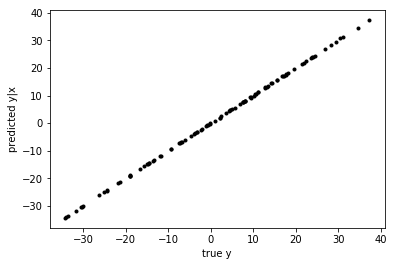

In [46]:
yhat_N = predict_y_given_x_with_NN(x_ND, true_nn_params)
assert yhat_N.size == N

plt.plot(yhat_N, y_N, 'k.')
plt.xlabel('true y')
plt.ylabel('predicted y|x')

### Example: Make predictions with 0-layer NN whose parameters  are filled with all zeros

Text(0, 0.5, 'predicted y|x')

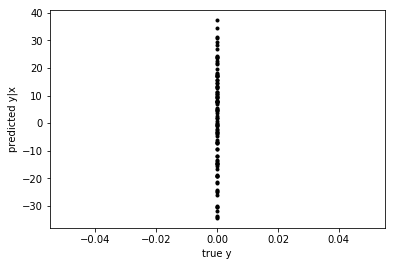

In [47]:
zero_nn_params = make_nn_params_as_list_of_dicts(n_hiddens_per_layer_list=[], n_dims_input=2, n_dims_output=1)
yhat_N = predict_y_given_x_with_NN(x_ND, zero_nn_params)
assert yhat_N.size == N

plt.plot(yhat_N, y_N, 'k.')
plt.xlabel('true y')
plt.ylabel('predicted y|x')

## Setup: Gradient descent implementation that can use list-of-dict parameters (not just arrays)

In [48]:
def run_many_iters_of_gradient_descent_with_list_of_dict(f, g, init_x_list_of_dict=None, n_iters=100, step_size=0.001):

    # Copy the initial parameter vector
    x_list_of_dict = copy.deepcopy(init_x_list_of_dict)

    # Create data structs to track the per-iteration history of different quantities
    history = dict(
        iter=[],
        f=[],
        x=[],
        g=[])
    start_time = time.time()
    for iter_id in range(n_iters):
        if iter_id > 0:
            # Gradient is a list of layer-specific dicts
            grad_list_of_dict = g(x_list_of_dict)
            for layer_id, x_layer_dict in enumerate(x_list_of_dict):
                for key in x_layer_dict.keys():
                    x_layer_dict[key] = x_layer_dict[key] - step_size * grad_list_of_dict[layer_id][key]
                    
        fval = f(x_list_of_dict)
        history['iter'].append(iter_id)
        history['f'].append(fval)
        history['x'].append(copy.deepcopy(x_list_of_dict))
        history['g'].append(g(x_list_of_dict))

        if iter_id < 3 or (iter_id+1) % 50 == 0:
            print("completed iter %5d/%d after %7.1f sec | loss %.6e" % (
                iter_id+1, n_iters, time.time()-start_time, fval))
    return x_list_of_dict, history

# Worked Exercise 5a: Train 0-layer NN via gradient descent on LINEAR toy data

In [49]:
def nn_regression_loss_function(nn_params):
    yhat_N = predict_y_given_x_with_NN(x_ND, nn_params)
    return 0.5 / ag_np.square(sigma) * ag_np.sum(np.square(y_N - yhat_N))

In [50]:
fromtrue_opt_nn_params, fromtrue_history = run_many_iters_of_gradient_descent_with_list_of_dict(
    nn_regression_loss_function,
    autograd.grad(nn_regression_loss_function),
    true_nn_params,
    n_iters=100,
    step_size=0.000001)

completed iter     1/100 after     0.0 sec | loss 4.343353e+01
completed iter     2/100 after     0.1 sec | loss 4.330311e+01
completed iter     3/100 after     0.1 sec | loss 4.319213e+01
completed iter    50/100 after     2.7 sec | loss 4.242465e+01
completed iter   100/100 after     5.2 sec | loss 4.234312e+01


In [51]:
pretty_print_nn_param_list(fromtrue_opt_nn_params)

Layer 0
  w | size    (2, 1) | [ 4.19568065 -4.19965201]
  b | size      (1,) | [0.09469614]


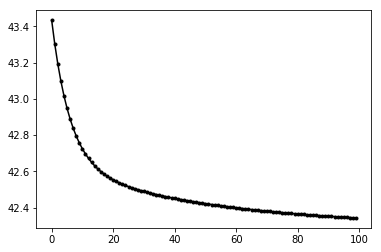

In [52]:
plt.plot(fromtrue_history['iter'], fromtrue_history['f'], 'k.-')

In [53]:
fromzero_opt_nn_params, fromzero_history = run_many_iters_of_gradient_descent_with_list_of_dict(
    nn_regression_loss_function,
    autograd.grad(nn_regression_loss_function),
    zero_nn_params,
    n_iters=100,
    step_size=0.000001)

completed iter     1/100 after     0.0 sec | loss 1.521585e+06
completed iter     2/100 after     0.1 sec | loss 1.270163e+06
completed iter     3/100 after     0.2 sec | loss 1.060293e+06
completed iter    50/100 after     2.8 sec | loss 2.686671e+02
completed iter   100/100 after     5.4 sec | loss 4.457975e+01


In [54]:
pretty_print_nn_param_list(fromzero_opt_nn_params)

Layer 0
  w | size    (2, 1) | [ 4.19465049 -4.19892163]
  b | size      (1,) | [0.11288017]


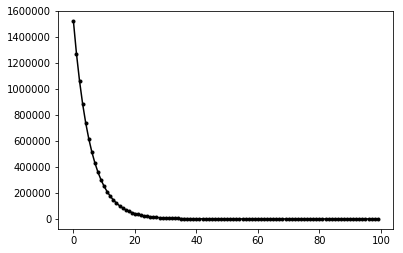

In [55]:
plt.plot(fromzero_history['iter'], fromzero_history['f'], 'k.-')

# Create more complex non-linear toy dataset

True method *regression from QUADRATIC features*:

$$
y \sim \text{Normal}( w_1 x_1 + w_2 x_2 + w_3 x_1^2 + w_4 x_2^2 + b, \sigma^2)
$$

In [56]:
N = 300
D = 2
sigma = 0.1

wsq_D = np.asarray([-2.0, 2.0])
w_D = np.asarray([4.2, -4.2])

train_prng = np.random.RandomState(0)
x_ND = train_prng.uniform(low=-5, high=5, size=(N,D))
y_N = (
    np.dot(np.square(x_ND), wsq_D)
    + np.dot(x_ND, w_D)
    + sigma * train_prng.randn(N))

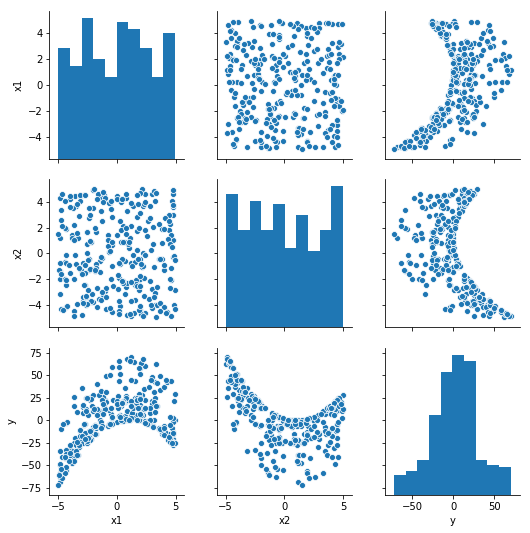

In [57]:
sns.pairplot(
    data=pd.DataFrame(np.hstack([x_ND, y_N[:,np.newaxis]]), columns=['x1', 'x2', 'y']));

In [58]:
def nonlinear_toy_nn_regression_loss_function(nn_params):
    yhat_N = predict_y_given_x_with_NN(x_ND, nn_params)
    return 0.5 / ag_np.square(sigma) * ag_np.sum(np.square(y_N - yhat_N))

In [59]:
# Initialize 1-layer, 10 hidden unit network with small random noise on weights

H10_init_nn_params = make_nn_params_as_list_of_dicts(
    n_hiddens_per_layer_list=[10], n_dims_input=2, n_dims_output=1,
    weight_fill_func=lambda sz_tuple: 0.1 * np.random.randn(*sz_tuple))

In [60]:
H10_opt_nn_params, H10_history = run_many_iters_of_gradient_descent_with_list_of_dict(
    nonlinear_toy_nn_regression_loss_function,
    autograd.grad(nonlinear_toy_nn_regression_loss_function),
    H10_init_nn_params,
    n_iters=300,
    step_size=0.000001)

completed iter     1/300 after     0.1 sec | loss 1.195763e+07
completed iter     2/300 after     0.3 sec | loss 1.165899e+07
completed iter     3/300 after     0.5 sec | loss 1.113150e+07
completed iter    50/300 after     9.5 sec | loss 3.516704e+06
completed iter   100/300 after    18.8 sec | loss 1.907578e+06
completed iter   150/300 after    29.2 sec | loss 1.964786e+06
completed iter   200/300 after    39.2 sec | loss 1.749155e+06
completed iter   250/300 after    51.1 sec | loss 1.575341e+06
completed iter   300/300 after    61.6 sec | loss 1.659934e+06


#### Plot objective function vs iters

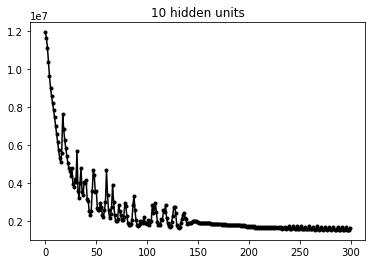

In [61]:
plt.plot(H10_history['iter'], H10_history['f'], 'k.-')
plt.title('10 hidden units');

#### Plot predicted y vs. true y for each example as a scatterplot

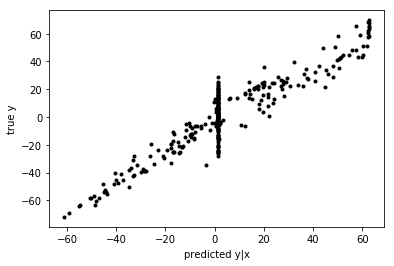

In [62]:
yhat_N = predict_y_given_x_with_NN(x_ND, H10_opt_nn_params)

plt.plot(yhat_N, y_N, 'k.');
plt.xlabel('predicted y|x');
plt.ylabel('true y');

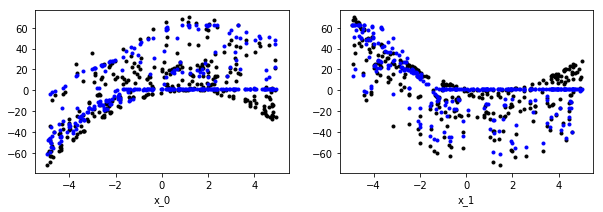

In [63]:
_, subplot_grid = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10,3), squeeze=False)
subplot_grid[0,0].plot(x_ND[:,0], y_N, 'k.');
subplot_grid[0,0].plot(x_ND[:,0], yhat_N, 'b.')
subplot_grid[0,0].set_xlabel('x_0');

subplot_grid[0,1].plot(x_ND[:,1], y_N, 'k.');
subplot_grid[0,1].plot(x_ND[:,1], yhat_N, 'b.')
subplot_grid[0,1].set_xlabel('x_1');

## More units! Try 1 layer with H=30 hidden units

In [64]:
# Initialize 1-layer, 30 hidden unit network with small random noise on weights
H30_init_nn_params = make_nn_params_as_list_of_dicts(
    n_hiddens_per_layer_list=[30], n_dims_input=2, n_dims_output=1,
    weight_fill_func=lambda sz_tuple: 0.1 * np.random.randn(*sz_tuple))

In [66]:
H30_opt_nn_params, H30_history = run_many_iters_of_gradient_descent_with_list_of_dict(
    nonlinear_toy_nn_regression_loss_function,
    autograd.grad(nonlinear_toy_nn_regression_loss_function),
    H30_init_nn_params,
    n_iters=50,
    step_size=0.000001)

completed iter     1/50 after     0.1 sec | loss 1.184375e+07
completed iter     2/50 after     0.2 sec | loss 1.087085e+07
completed iter     3/50 after     0.4 sec | loss 9.449709e+06
completed iter    50/50 after     6.7 sec | loss 2.035457e+06


#### Plot objective function vs iterations

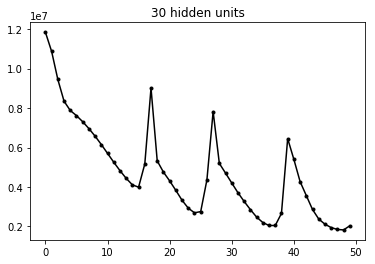

In [67]:
plt.plot(H30_history['iter'], H30_history['f'], 'k.-');
plt.title('30 hidden units');

#### Plot predicted y value vs true y value for each example

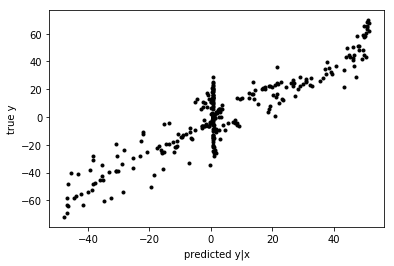

In [68]:
yhat_N = predict_y_given_x_with_NN(x_ND, H30_opt_nn_params)

plt.plot(yhat_N, y_N, 'k.');
plt.xlabel('predicted y|x');
plt.ylabel('true y');

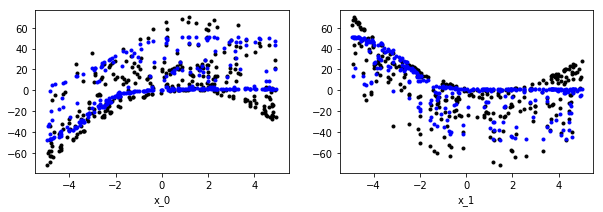

In [69]:
_, subplot_grid = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10,3), squeeze=False)
subplot_grid[0,0].plot(x_ND[:,0], y_N, 'k.');
subplot_grid[0,0].plot(x_ND[:,0], yhat_N, 'b.')
subplot_grid[0,0].set_xlabel('x_0');

subplot_grid[0,1].plot(x_ND[:,1], y_N, 'k.');
subplot_grid[0,1].plot(x_ND[:,1], yhat_N, 'b.')
subplot_grid[0,1].set_xlabel('x_1');

## Even more units! Try 1 layer with H=100 hidden units

In [70]:
# Initialize 1-layer, 100 hidden unit network with small random noise on weights
H100_init_nn_params = make_nn_params_as_list_of_dicts(
    n_hiddens_per_layer_list=[100], n_dims_input=2, n_dims_output=1,
    weight_fill_func=lambda sz_tuple: 0.05 * np.random.randn(*sz_tuple))

In [72]:
H100_opt_nn_params, H100_history = run_many_iters_of_gradient_descent_with_list_of_dict(
    nonlinear_toy_nn_regression_loss_function,
    autograd.grad(nonlinear_toy_nn_regression_loss_function),
    H100_init_nn_params,
    n_iters=30,
    step_size=0.0000005)

completed iter     1/30 after     0.1 sec | loss 1.194856e+07
completed iter     2/30 after     0.2 sec | loss 1.140156e+07
completed iter     3/30 after     0.3 sec | loss 1.064044e+07


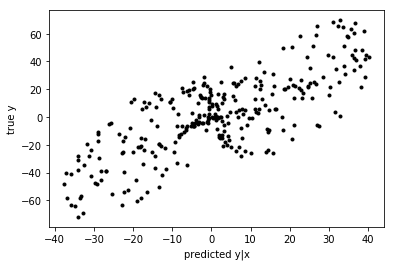

In [73]:
yhat_N = predict_y_given_x_with_NN(x_ND, H100_opt_nn_params)

plt.plot(yhat_N, y_N, 'k.');
plt.xlabel('predicted y|x');
plt.ylabel('true y');

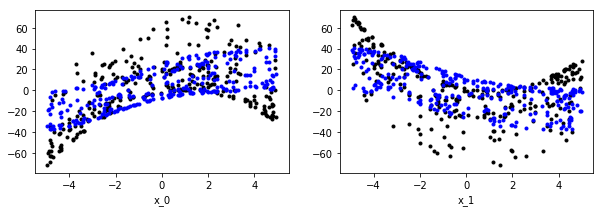

In [74]:
_, subplot_grid = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10,3), squeeze=False)
subplot_grid[0,0].plot(x_ND[:,0], y_N, 'k.');
subplot_grid[0,0].plot(x_ND[:,0], yhat_N, 'b.')
subplot_grid[0,0].set_xlabel('x_0');

subplot_grid[0,1].plot(x_ND[:,1], y_N, 'k.');
subplot_grid[0,1].plot(x_ND[:,1], yhat_N, 'b.')
subplot_grid[0,1].set_xlabel('x_1');

# Try it yourself!

* Can you train a prediction network on the non-linear toy data so it has ZERO training error? Is this even possible?

* Can you make the network train faster? What happens if you play with the step_size?

* What if you made the network **deeper** (more layers)?

* What other dataset would you want to try out this regression on?